# How municipal median income affects the results of Finnish matriculation examination results

# 1. Abstract
In this study we gauge the effects of median income for a municipality on the results of the matriculation exam in different schools. We also form a modelin order to predict the finnish matriculation exam results for individual schools for the autumn term 2018.

# 2. Introduction and description of data

## Income data
Income data for different municipalities was obtained from the table incomes statistics, provided by Statistics Finland. Data for all finnish municipalities was available for the years 2005 - 2016. The data was obtained from the open data set provided by Statistics Finland on ther offical website [d1].

The data consists of metrics for each municipality. For each year there is one datum per municipality. The data contains the following variables of interest:
* $\texttt{year}$
* $\texttt{municipality}$, name of the municipality
* $\texttt{Number of income recipients}$
* $\texttt{Taxable income, median}$
* $\texttt{Municipal tax, mean}$
* Additional variables were not considered

The income data was joined with data linking each municipality name to a municipality code.

## Matriculation examination data
The Finnish matriculation examination is a naition-wide standardised test for upper secondary school. Students are given questions on different topics on multiple occasions in varying subjects, such as mother tongue, mathematics, physics, biology, languages and more. The exam is held twice a year (autumn and spring).

The exam is graded on a scale of 1-7: laudatur (L), eximia cum laude approbatur (E), magna cum laude approbatur (M), cum laude approbatur (C), lubenter approbatur (B), approbatur (A) and improbatur (I).

Data for the examination for all participating schools results was avaiable for the years 2012 - 2018 (spring). We used data for the years XX-YY. The data was obtained from the open data set provided by the Matriculation examinaton board on ther offical website [d2].

The data consists of a set of metrics for each school. For each year there is two datum per shool, one for each round. The data contains thefollowing variables of interest:
* $\texttt{round}$, examination round
* $\texttt{year}$, the year-part of the round
* $\texttt{season}$, the season part of the round (K=spring, S=autumn)
* $\texttt{school_id}$, school id number
* $\texttt{mean_ob}$, school mean of obligatory subject scores
* $\texttt{mean}$, school mean of all subjects
* $\texttt{n}$, number of students (for above metrics)
* $\texttt{mean_pkr}$, school mean of "advanced" subjects
* $\texttt{n_pkr}$, number of students (for above metric)
* Additional variables were not considered

The matriculation examination data was joined with data linking each school id to a municipality code.




In [3]:
import numpy as np
import pandas as pd
from data import Data
import config
import matplotlib.pyplot as plt

# Load income and examination result data
df_income, df_results = Data.load()
df_all = pd.merge(df_results, df_income, on=["municipality_code", "year"], how='inner')

# 3. Hypothesis

Schools in municipalities with a higher median income will perform better in matriculation exams, than schools in municipalities with lower median income.

Our null hypothesis is thus
$$H_0: \mu_{\text{high median income}} = \mu_{\text{low median income}}$$
where $\mu$ is the mean of examination results for a school within a municipality, with a certain median income.

# 4. Analysis of data
The data has N dimensions, and we use K.

In [4]:
df_all.head()

,round,school_id,pass,hylatty,h_tai_k,graduated,mean_ob,mean,n,mean_pkr,n_pkr,municipality_code,year,season,municipality,number of income recipients,"taxable income, mean","taxable income, median"
0,2014K,1001,35,2.0,2.0,35,3.94,3.88,5.60,3.94,4.37,233,2014,K,Kauhava,14280,25046,21070
1,2014K,1269,57,2.0,2.0,56,4.48,4.40,5.07,4.52,3.86,233,2014,K,Kauhava,14280,25046,21070
2,2014S,1001,1,1.0,1.0,1,3.25,3.17,6.00,3.20,5.00,233,2014,S,Kauhava,14280,25046,21070
3,2014S,1269,1,1.0,1.0,1,3.25,3.00,5.00,3.00,4.00,233,2014,S,Kauhava,14280,25046,21070
4,2014K,1002,63,3.0,4.0,62,4.11,4.04,5.62,4.16,4.67,5,2014,K,Alajärvi,8372,22634,18729


## Bivariate analysis
The correlation matrix of selected fields in the data is calculated below.

In [5]:
# Univariate co-variance
df_quantitative = df_all.drop(columns=['municipality','municipality_code','round','school_id','season', 'graduated', 'hylatty', 'h_tai_k','year','n','n_pkr'])
df_centered = df_quantitative - df_quantitative.mean()
df_standard = df_centered / df_centered.std()

df_standard.cov()

,pass,mean_ob,mean,mean_pkr,number of income recipients,"taxable income, mean","taxable income, median"
pass,1.000000,0.407887,0.413399,0.404490,0.237565,0.223787,0.235225
mean_ob,0.407887,1.000000,0.989239,0.972556,0.219633,0.165333,0.126628
mean,0.413399,0.989239,1.000000,0.978917,0.221414,0.159225,0.118550
mean_pkr,0.404490,0.972556,0.978917,1.000000,0.216461,0.146029,0.106030
number of income recipients,0.237565,0.219633,0.221414,0.216461,1.000000,0.537727,0.478087
"taxable income, mean",0.223787,0.165333,0.159225,0.146029,0.537727,1.000000,0.918734
"taxable income, median",0.235225,0.126628,0.118550,0.106030,0.478087,0.918734,1.000000


We also plotted the scatterplot of the two variables of interest

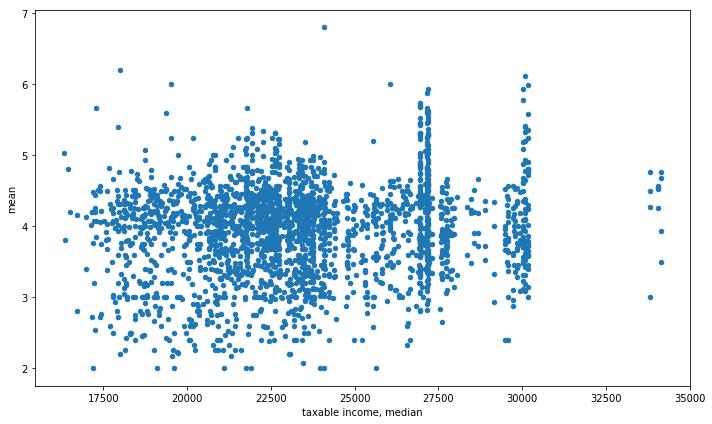

In [6]:
# Simple scatter plot of mean vs. median income
df_all.plot.scatter(x='taxable income, median',y='mean',figsize=(10,6))
plt.tight_layout()

There are distinct clusters in the data

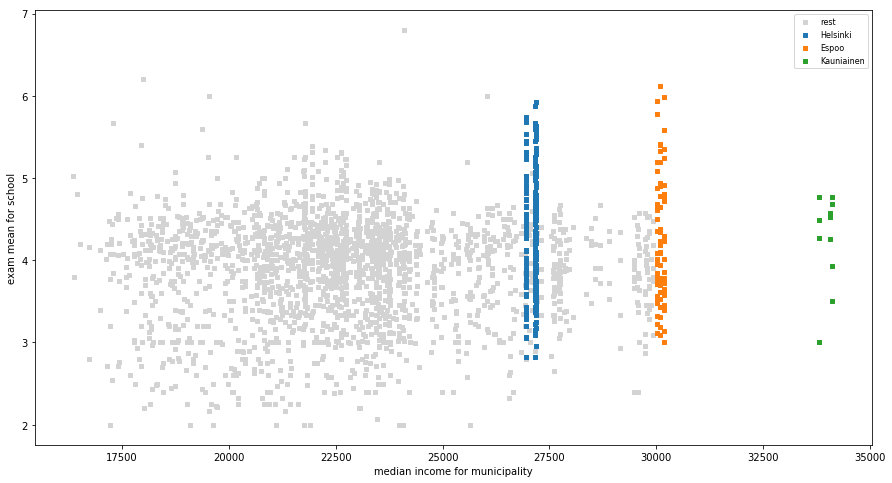

In [7]:
def plot_municipality(
        df,
        x_variable="taxable income, median",
        y_variable="mean",
        xlabel='median income for municipality',
        ylabel='exam mean for school',
        min_n=1,
        selected_classes=None):
    """Plot scatterplot hilighting certain selected_classes"""
    class_variable = 'municipality'
    if selected_classes == None:
        df_sorted_unique = df_all.drop_duplicates(subset="municipality").nlargest(20, "taxable income, median")
        # Apply min_n condition
        df_sorted_unique = df_sorted_unique[(df_sorted_unique['pass'] >= min_n)]
        selected_classes = np.unique(df_sorted_unique[[class_variable]].values.flatten())
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot rest
    # Filter non-selected variables, with n_min conditon
    d = df[(~df[class_variable].isin(selected_classes)) & (df['pass'] >= min_n)]
    x = d.loc[:, x_variable].values
    y = d.loc[:, y_variable].values
    ax.scatter(x, y, 10, marker=',', label='rest',c='lightgray')
    
    # Plot selected
    for i, c in enumerate(selected_classes):
        # Filter selected variables, with n_min conditon
        d = df.loc[(df[class_variable] == c) & (df['pass'] >= min_n)]
        x = d.loc[:, x_variable].values
        y = d.loc[:, y_variable].values
        ax.scatter(x, y, 10, marker=',', label=c)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend(loc=1, prop={'size': 8})
    plt.show()
    
#plot_municipality(df_all)
plot_municipality(df_all, selected_classes=['Helsinki', 'Espoo', 'Kauniainen'])


The initial unprocessed data clearly has multiple clusters, where the largest urban cities deviate from the rest of the country. 

In [8]:
p = df_centered['mean'].corr(df_centered['taxable income, mean'])
print("Pearson corr. coef:",round(p, 3))

Pearson corr. coef: 0.159


The analysis without any outlier removal or data preprocessing has a correlation of $p=0.159$.

# 5. Methods
Dolor cit amet.

##  5.1 Linear Model
A linear model was fit to the data to gauge the hypothesis. The mean exam results, $y$, are assumed to follow a normal distribution:
$$
y \sim \mathcal{N}(\mu_\text{school}, \sigma)
$$
where $\sigma$ is population level standard deviation, and 
$$
\mu_\text{school} = \alpha + \beta x \\
\beta \sim \mathcal{N}(0, \sigma_0)
$$
Here $\beta$ is the slope of the line.
### Priors
Lorem ipsum.

# 6. Experiments
## 6.1 Linear model
Loerm ipsum.

In [12]:
import model_utils
from model_utils import Model

import logging
logging.getLogger("pystan").setLevel(logging.ERROR)



# Sample
print("Using a sample for calculations")
excluded_munis = ['Helsinki', 'Espoo', 'Kauniainen']
df = df_all[(~df_all['municipality'].isin(excluded_munis)) & (df_all['season'] == 'K')]
# df = df_all[(df_all['season'] == 'K')]
sample = df.sample(frac=0.5, random_state=1)

# Prepare data
N, d = sample.shape
y = sample['mean']
x = sample['taxable income, median']

data = dict(
    N=N,
    x=x,
    y=y,
    sigma0=0.5
)


# Prepare stan
print("Compiling model...")
model = Model('model.linear.stan')
print("Fitting data to model...")
fit = model.sample(data=data, iter=500)
samples = fit.extract(permuted=True)
print("Fitted...")

Using a sample for calculations
Compiling model...
Using cached StanModel
Fitting data to model...
Fitted...


# References

[1] Multivariate Analysis (1979, 2003 reprint)  
Mardia, K.V., Kent, J.T., Bibby, J.M. Academic Press, ISBN 0-12-471252-5 Pbk

# Data sources
[d1] Data on taxablew income in Finland, for the years XX-YY  
     http://www.stat.fi/meta/til/tvt_en.html

[d2] Matriculation exam metrics for the schools in Finland, for the years XX-YY  
     https://www.ylioppilastutkinto.fi/tietopalvelut/tilastot/koulukohtaisia-tunnuslukuja
     
